# ADA Project : Milestone 2

## Imports and Data

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Data from RateBeer 'RB'
beers_RB = pd.read_table("./data/RateBeer/beers.csv", sep=",")
breweries_RB = pd.read_table("./data/RateBeer/breweries.csv", sep=",")
users_RB = pd.read_table("./data/RateBeer/users.csv", sep=",")
ratings_RB = pd.read_table("./data/RateBeer/ratings.csv", sep=",")

In [44]:
# Data from BeerAdvocate 'BA'
beers_BA = pd.read_table("./data/BeerAdvocate/beers.csv", sep=",")
breweries_BA = pd.read_table("./data/BeerAdvocate/breweries.csv", sep=",")
users_BA = pd.read_table("./data/BeerAdvocate/users.csv", sep=",")
ratings_BA = pd.read_table("./data/BeerAdvocate/ratings.csv", sep=",")

In [5]:
# Data from MixedDataset 'MD'
beers_MD = pd.read_table("./data/matched_beer_data/beers.csv", sep=",")
breweries_MD = pd.read_table("./data/matched_beer_data/breweries.csv", sep=",")
users_MD = pd.read_table("./data/matched_beer_data/users.csv", sep=",")
users_approx_MD = pd.read_table("./data/matched_beer_data/users_approx.csv", sep=",")
ratings_MD = pd.read_table("./data/matched_beer_data/ratings.csv", sep=",")

C:\Users\Mathi\AppData\Local\Temp\ipykernel_29604\3246452614.py:2: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_MD = pd.read_table("./data/matched_beer_data/beers.csv", sep=",")
C:\Users\Mathi\AppData\Local\Temp\ipykernel_29604\3246452614.py:6: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_MD = pd.read_table("./data/matched_beer_data/ratings.csv", sep=",")


## Seasonal analysis of the number of reviews per type of beer

In [6]:
import datetime as dt

# create sub_dataframe with type of beer and date
df_count_type_season = df[['type','date']].dropna()

# create extra column with the day in year corresponding to the date
df_count_type_season['day_of_year'] = df_count_type_season['date'].dt.dayofyear

num_bins = 10
bins = 365/num_bins * np.range(1, num_bins + 1)
groups = df.groupby(['type', pd.cut(df.day_of_year, bins)])
print(groups.size().unstack())
groups.plot(type='line')

exit()

# for loop on the different type of beer
types = pd.unique(df_count_type_season['type'])

plt.figure(figsize=(5,5))
for beertype in types:
    df_count = df_count_type_season[df_count_type_season['type'] == beertype][day_of_year].group_by('day_of_year').count()
    print(df_count.iloc[:5])
    
    # count per day (or broader bins)
    # plot

NameError: name 'df' is not defined

## Number of review per day using rolling average

In [80]:


# Assuming the file is named 'beer_ratings.csv' and is located in the same directory as your script.
# Read the CSV file
BA_NR_RW_DAY=ratings_BA
# Convert the Unix time to a datetime object, assuming the 'date' column is Unix time in seconds
BA_NR_RW_DAY['date'] = pd.to_datetime(BA_NR_RW_DAY['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later
BA_NR_RW_DAY_WW = BA_NR_RW_DAY[(BA_NR_RW_DAY['date'] >= start_date) & (BA_NR_RW_DAY['date'] <= end_date)]


date
2015-01-01    4985
2015-01-02    4184
2015-01-03    4875
2015-01-04    4888
2015-01-05    3554
              ... 
2015-12-27    3740
2015-12-28    3379
2015-12-29    3292
2015-12-30    3308
2015-12-31    3730
Length: 365, dtype: int64


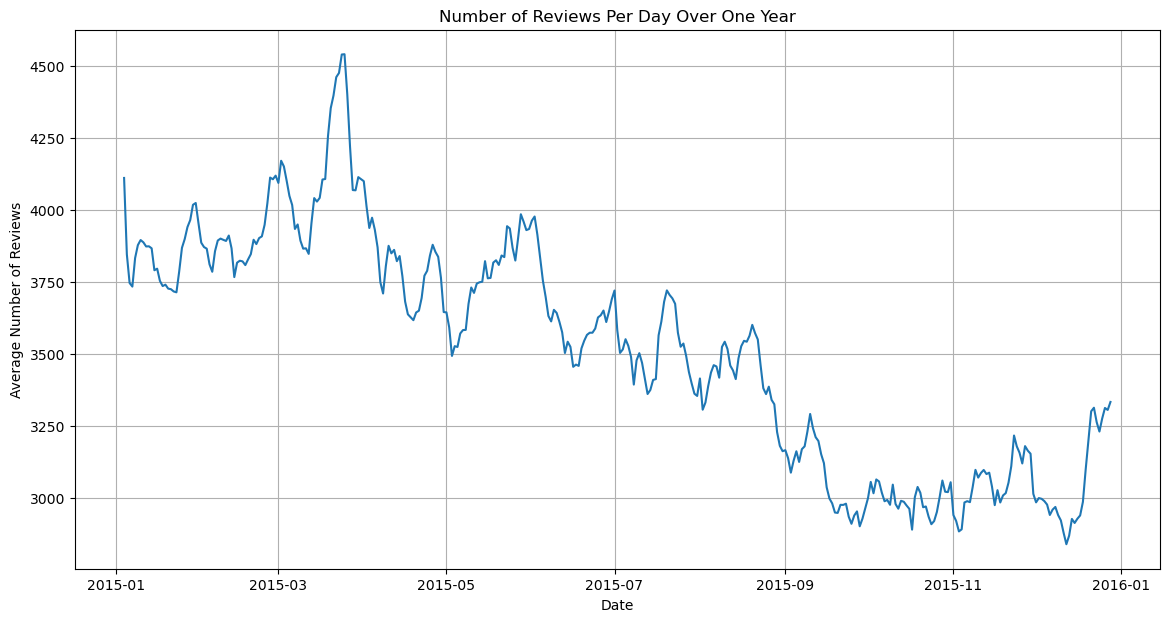

In [110]:
# Group by the date and count the reviews
def plot_rolling(df, window=7):
    daily_reviews = df.groupby(df['date'].dt.date).size()
    print(daily_reviews)
    # Calculate the moving average with a window size of 7 to remove weeks days
    rolling = daily_reviews.rolling(window=window, center=True)
    rolling_average = rolling.mean()
    
    # Plot the rolling average
    plt.figure(figsize=(14, 7))
    rolling_average.plot(title='Number of Reviews Per Day Over One Year')
    
    # Add labels and grid
    plt.xlabel('Date')
    plt.ylabel('Average Number of Reviews')
    plt.grid(True)
    plt.show()
plot_rolling(BA_NR_RW_DAY_WW)

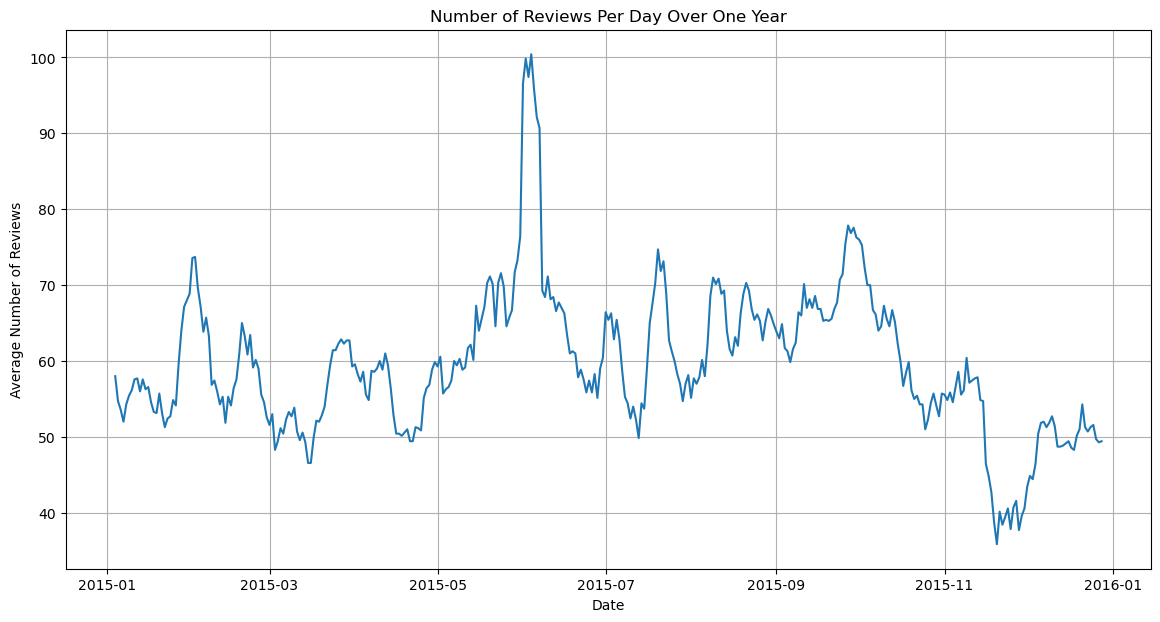

In [98]:
german_beers= ratings_BA[ratings_BA["brewery_id"].isin(breweries_BA[breweries_BA['location']=='Germany']['id'])]
german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_beers_WW = german_beers[(german_beers['date'] >= start_date) & (german_beers['date'] <= end_date)]
plot_rolling(german_beers_WW)

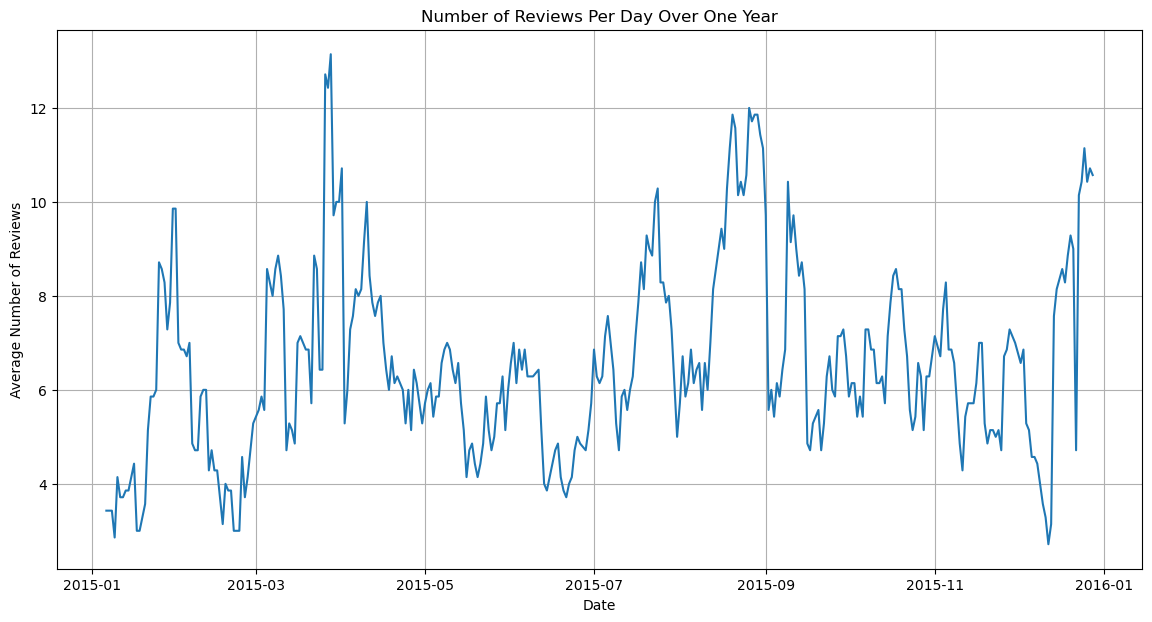

In [106]:
german_users= ratings_BA[ratings_BA["user_id"].isin(users_BA[users_BA['location']=='Germany']['user_id'])]
#german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_users_WW = german_users[(german_users['date'] >= start_date) & (german_users['date'] <= end_date)]
plot_rolling(german_users_WW, 7)

## Analysis 3

## Analysis 4